In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf


/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.24.3
  tensorflow version:  2.13.1





## Set model and resolution parameters

In [3]:
train_mu0 = 0.
train_mu1 = 1.
train_rho01 = -0.6

train_sig0 = 1.0
train_sig1 = 1.5

train_cov00 = train_sig0 * train_sig0 
train_cov11 = train_sig1 * train_sig1
train_cov01 = train_rho01 * train_sig0 * train_sig1

train_cov = np.array( [[train_cov00, train_cov01], [train_cov01, train_cov11]] )
train_mu = np.array( [train_mu0, train_mu1])



true_mu0 = 0.2
true_mu1 = 0.8
true_rho01 = -0.6

true_sig0 = 0.9
true_sig1 = 1.3

true_cov00 = true_sig0 * true_sig0 
true_cov11 = true_sig1 * true_sig1
true_cov01 = true_rho01 * true_sig0 * true_sig1

true_cov = np.array( [[true_cov00, true_cov01], [true_cov01, true_cov11]] )
true_mu = np.array( [true_mu0, true_mu1])



#--- resolution is in same dimensions as features (not sigma/val)
res0 = 0.5
res1 = 0.8




## Plots to visualize these parameter choices

In [4]:

ngen_train = 100000
ngen_true = 10000

train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, [res0, res1])

true_det_pts = np.random.normal( true_pts, [res0, res1])



<function matplotlib.pyplot.show(close=None, block=None)>

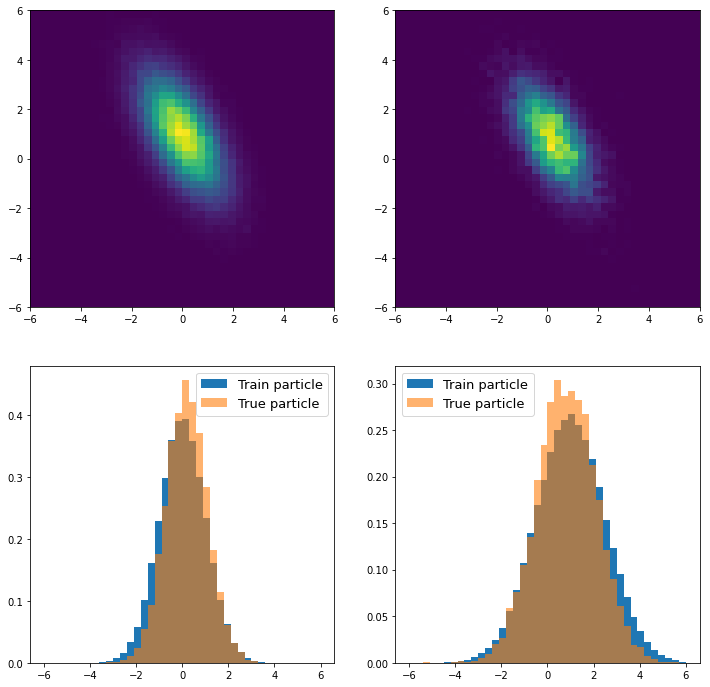

In [5]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_pts[:,0], train_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_pts[:,0], true_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='Train particle' )
ax[1][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='True particle', alpha=0.6)

ax[1][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='Train particle' )
ax[1][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='True particle', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

In [6]:
train_diff = train_det_pts - train_pts

In [7]:
diff_cov = np.cov( train_diff.T )

In [8]:
diff_cov

array([[ 2.51446067e-01, -3.38783910e-04],
       [-3.38783910e-04,  6.42452893e-01]])

In [9]:
np.sqrt(diff_cov[0,0])

0.5014439819856906

In [10]:
np.sqrt(diff_cov[1,1])

0.8015315919868835

<function matplotlib.pyplot.show(close=None, block=None)>

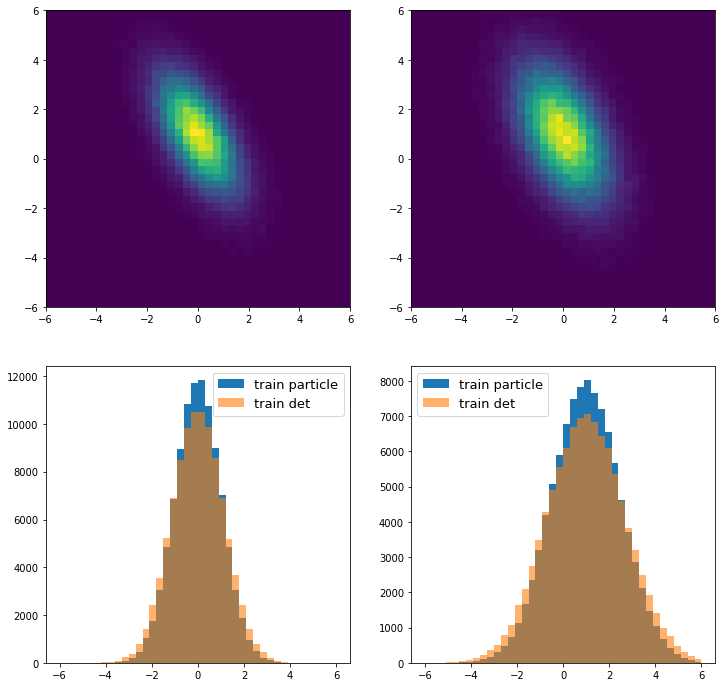

In [11]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_pts[:,0], train_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( train_det_pts[:,0], train_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], label='train particle' )
ax[1][0].hist( train_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='train det', alpha=0.6)

ax[1][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], label='train particle' )
ax[1][1].hist( train_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='train det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

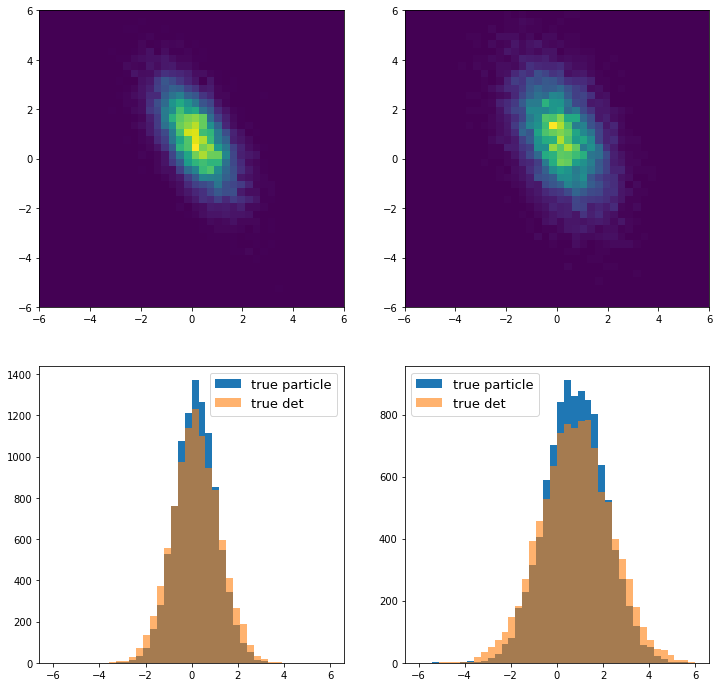

In [12]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( true_pts[:,0], true_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_det_pts[:,0], true_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], label='true particle' )
ax[1][0].hist( true_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='true det', alpha=0.6)

ax[1][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], label='true particle' )
ax[1][1].hist( true_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='true det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

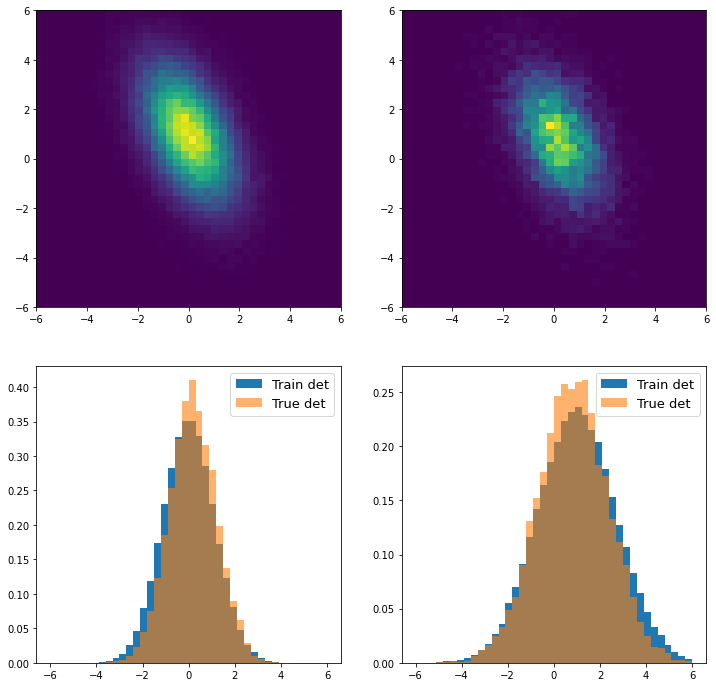

In [13]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_det_pts[:,0], train_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_det_pts[:,0], true_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='Train det' )
ax[1][0].hist( true_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='True det', alpha=0.6)

ax[1][1].hist( train_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='Train det' )
ax[1][1].hist( true_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='True det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

## Set up NN model for OmniFold

In [14]:
inputs = Input((2, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

## Package the training data for OmniFold

In [15]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [16]:
%%time


verbose = True

of_niter = 4

of_weights = of.omnifold( train_both, true_det_pts, of_niter, model, verbose)




  shape of theta0_S : (100000, 2)
  shape of theta_unknown_S : (10000, 2)
  shape of xvals_1 :  (110000, 2)



  shape of labels0 : (100000,)
  shape of labels_unknown : (10000,)
  shape of yvals_1 :  (110000,)



  shape of theta0_G : (100000, 2)
  shape of xvals_2 :  (200000, 2)
  shape of yvals_2 :  (200000,)




ITERATION: 1

   -- ITERATION 1  STEP 1

Epoch 1/20
9/9 [==============================] - 1s 30ms/step - loss: 0.6313 - accuracy: 0.4635 - val_loss: 0.5606 - val_accuracy: 0.4541
Epoch 2/20
9/9 [==============================] - 0s 11ms/step - loss: 0.5211 - accuracy: 0.4547 - val_loss: 0.4666 - val_accuracy: 0.4541
Epoch 3/20
9/9 [==============================] - 0s 10ms/step - loss: 0.4278 - accuracy: 0.4547 - val_loss: 0.3799 - val_accuracy: 0.4541
Epoch 4/20
9/9 [==============================] - 0s 9ms/step - loss: 0.3551 - accuracy: 0.4547 - val_loss: 0.3365 - val_accuracy: 0.4541
Epoch 5/20
9/9 [==============================] - 0s 9ms/step - loss: 0.3307 - accu

9/9 [==============================] - 0s 9ms/step - loss: 0.1283 - accuracy: 0.3892 - val_loss: 0.1291 - val_accuracy: 0.3923
Epoch 16/20
9/9 [==============================] - 0s 9ms/step - loss: 0.1283 - accuracy: 0.3884 - val_loss: 0.1291 - val_accuracy: 0.3898
Epoch 17/20
9/9 [==============================] - 0s 9ms/step - loss: 0.1283 - accuracy: 0.3925 - val_loss: 0.1291 - val_accuracy: 0.3942
Epoch 18/20
9/9 [==============================] - 0s 9ms/step - loss: 0.1283 - accuracy: 0.4011 - val_loss: 0.1291 - val_accuracy: 0.3996
Epoch 19/20
9/9 [==============================] - 0s 9ms/step - loss: 0.1283 - accuracy: 0.3900 - val_loss: 0.1291 - val_accuracy: 0.3836
Epoch 20/20
10/10 [==============================] - 0s 2ms/step

   -- ITERATION 2  STEP 2

Epoch 1/20
75/75 [==============================] - 1s 4ms/step - loss: 0.2034 - accuracy: 0.2507 - val_loss: 0.1659 - val_accuracy: 0.2505
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 0.1663 - acc

75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2500 - val_loss: 0.1641 - val_accuracy: 0.2501
Epoch 12/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2500 - val_loss: 0.1641 - val_accuracy: 0.2501
Epoch 13/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2500 - val_loss: 0.1641 - val_accuracy: 0.2501
Epoch 14/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2500 - val_loss: 0.1641 - val_accuracy: 0.2501
Epoch 15/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2500 - val_loss: 0.1642 - val_accuracy: 0.2501
Epoch 16/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2500 - val_loss: 0.1641 - val_accuracy: 0.2501
Epoch 17/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.2500 - val_loss: 0.1642 - val_accuracy: 0.2501
Epoch 18/20
75/75 [======

In [17]:
of_weights

array([[[0.16153702, 0.12188266, 0.02050918, ..., 0.08783625,
         0.08204573, 0.06503293],
        [0.12700182, 0.12657475, 0.06142959, ..., 0.10314942,
         0.12222166, 0.09786085]],

       [[0.93712556, 0.94170153, 0.84274334, ..., 0.97332209,
         1.06726861, 0.86046499],
        [0.11314268, 0.12350737, 0.05189887, ..., 0.09908604,
         0.13118419, 0.085521  ]],

       [[0.96221948, 0.94709408, 0.89337677, ..., 0.96971166,
         1.07707345, 0.90218681],
        [0.10987739, 0.11191656, 0.04739282, ..., 0.08948737,
         0.13217708, 0.0860842 ]],

       [[1.05874705, 1.03832126, 0.95639485, ..., 0.99953806,
         1.10433459, 0.8891862 ],
        [0.11273387, 0.11958432, 0.04598216, ..., 0.09617724,
         0.13995498, 0.0811051 ]]])

In [18]:
np.shape( of_weights)

(4, 2, 100000)

<function matplotlib.pyplot.show(close=None, block=None)>

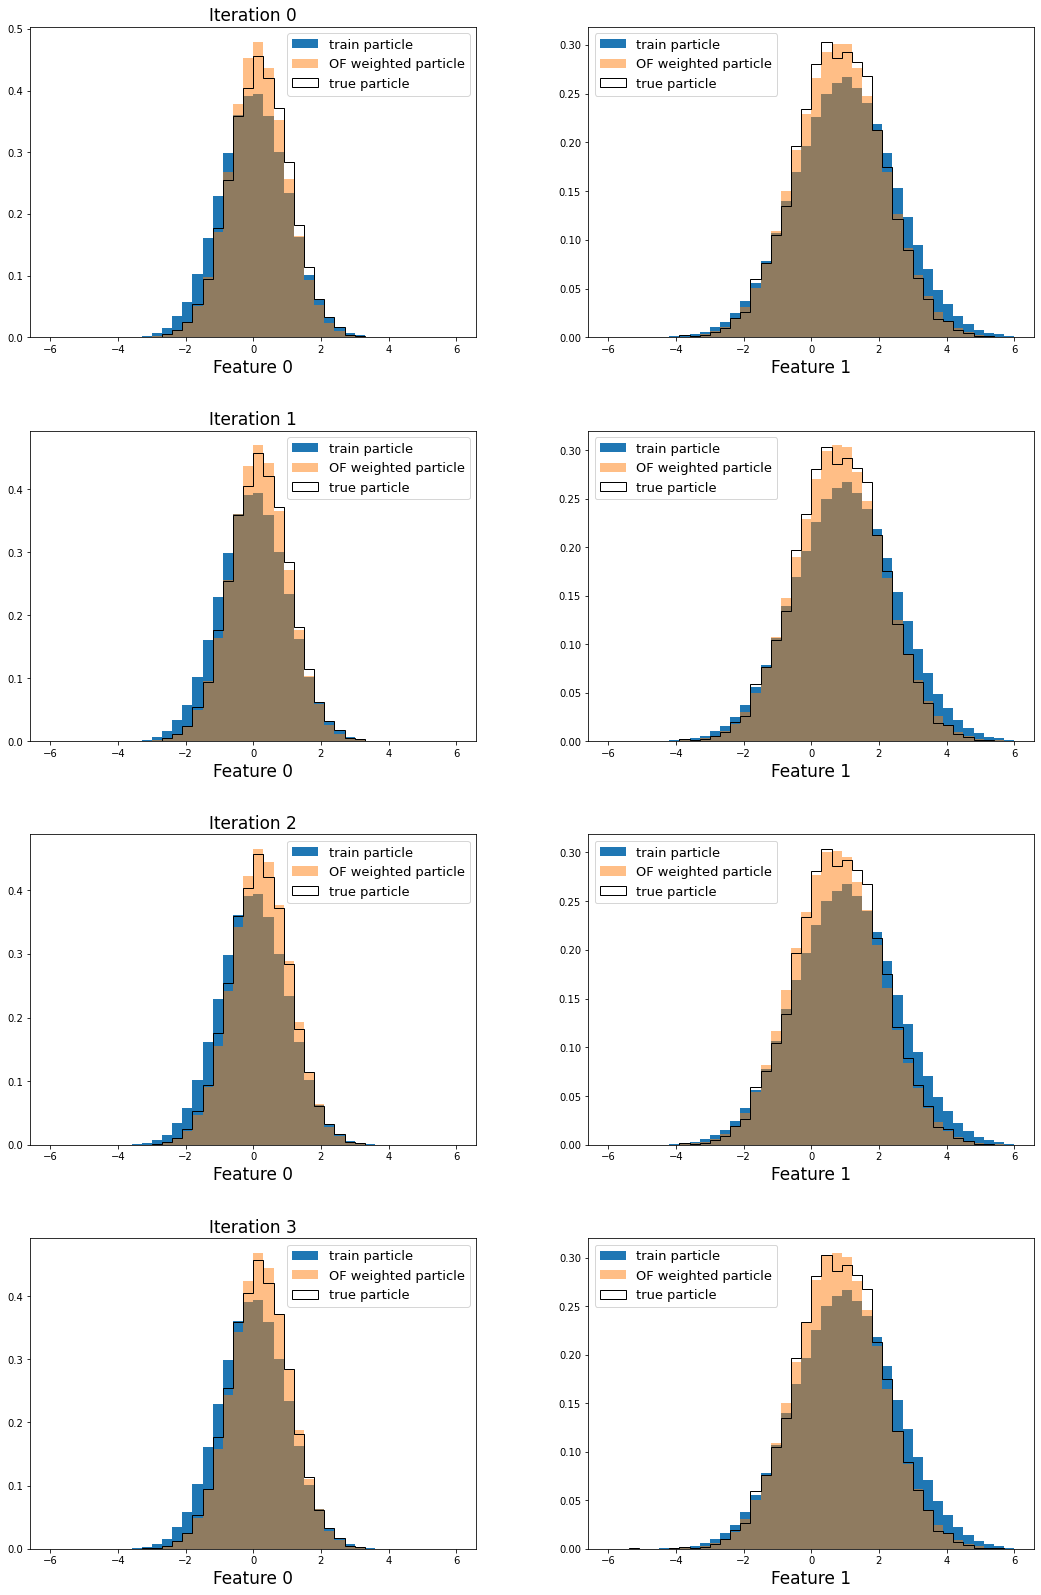

In [19]:


fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)



for ofi in range(0,of_niter) :

    ax[ofi][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='train particle' )
    ax[ofi][0].hist( train_pts[:,0], weights=of_weights[ofi,1,:], bins=hbins, range=[hmin,hmax], density=True, label='OF weighted particle', alpha=0.5 )
    ax[ofi][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='true particle', histtype='step', color='black' )

    ax[ofi][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='train particle' )
    ax[ofi][1].hist( train_pts[:,1], weights=of_weights[ofi,1,:], bins=hbins, range=[hmin,hmax], density=True, label='OF weighted particle', alpha=0.5 )
    ax[ofi][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='true particle', histtype='step', color='black' )


    ax[ofi][0].legend(loc='best', fontsize=13)
    ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

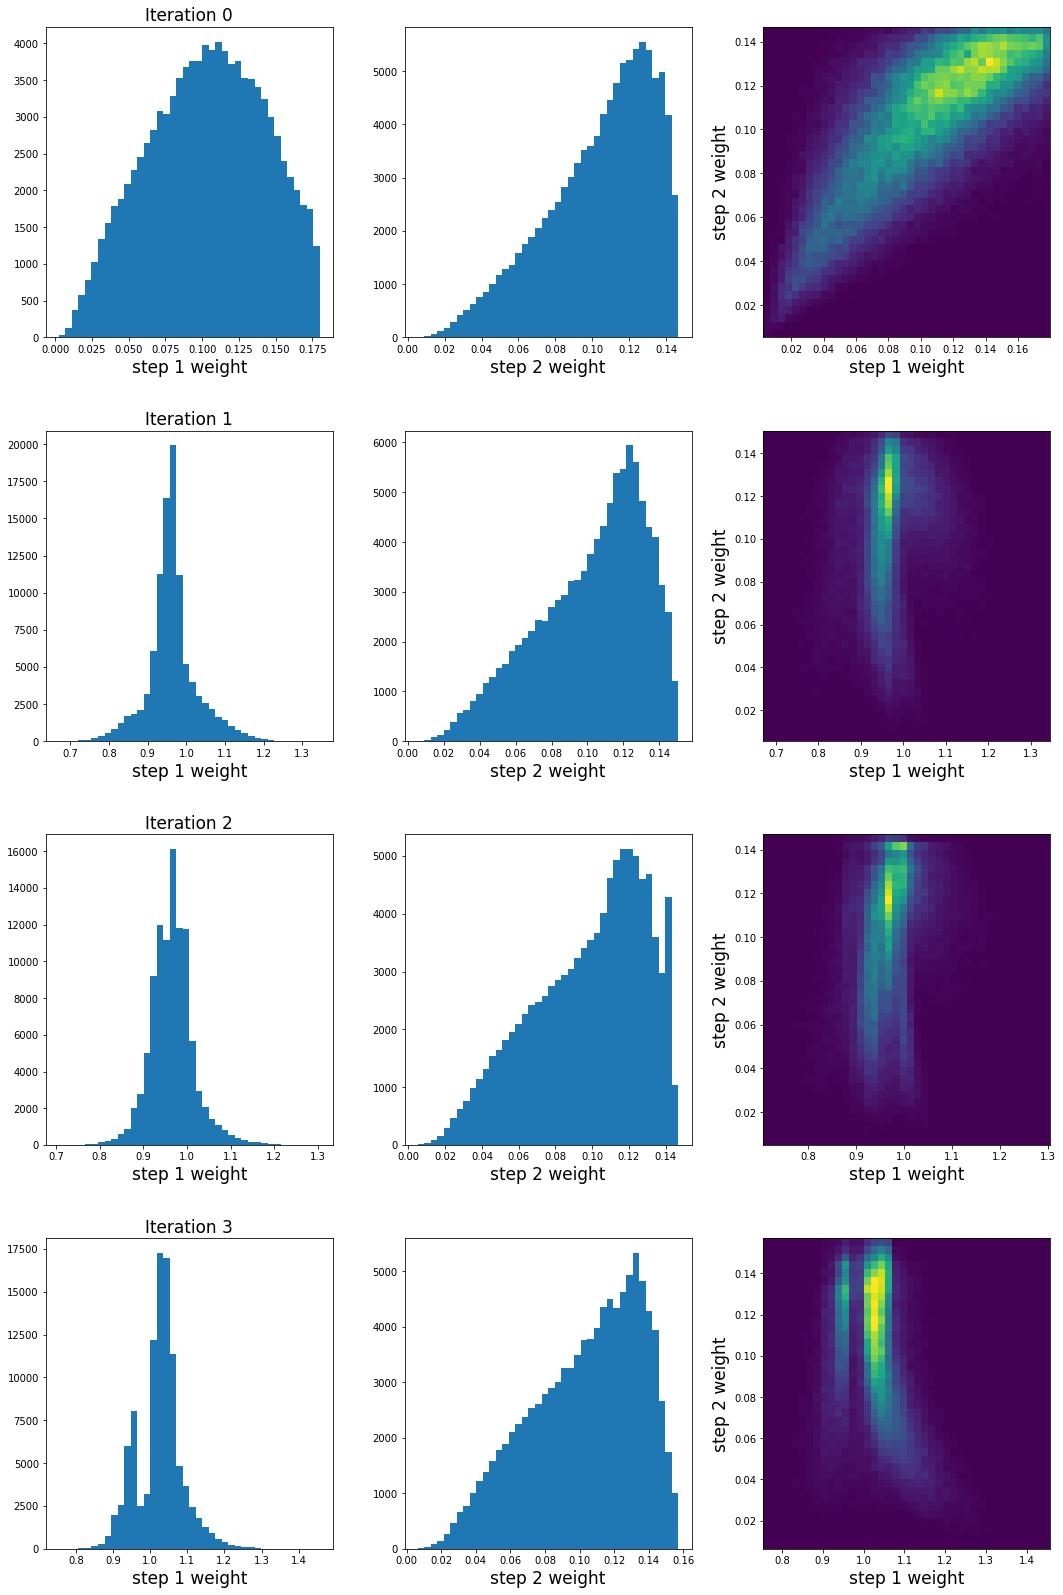

In [20]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

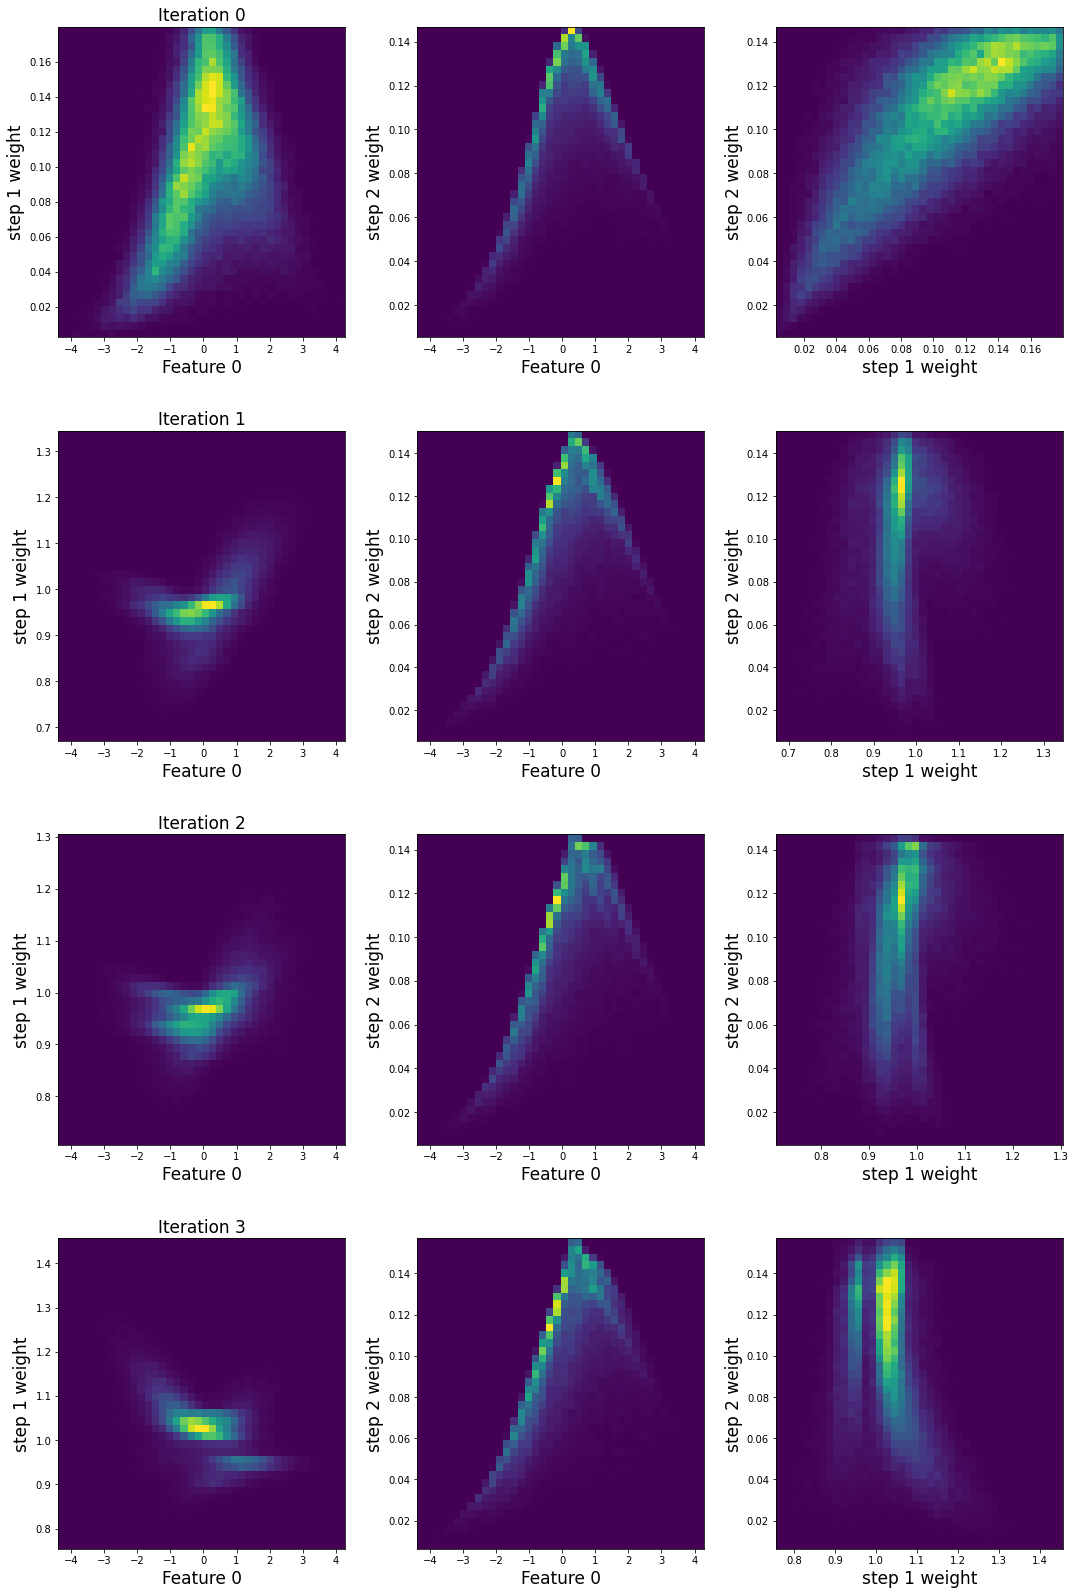

In [21]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist2d( train_pts[:,0], of_weights[ofi,0,:], bins=[hbins,hbins] )
    ax[ofi][1].hist2d( train_pts[:,0], of_weights[ofi,1,:], bins=[hbins,hbins] )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'Feature 0', fontsize=lfontsize )
    ax[ofi][0].set_ylabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'Feature 0', fontsize=lfontsize )
    ax[ofi][1].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

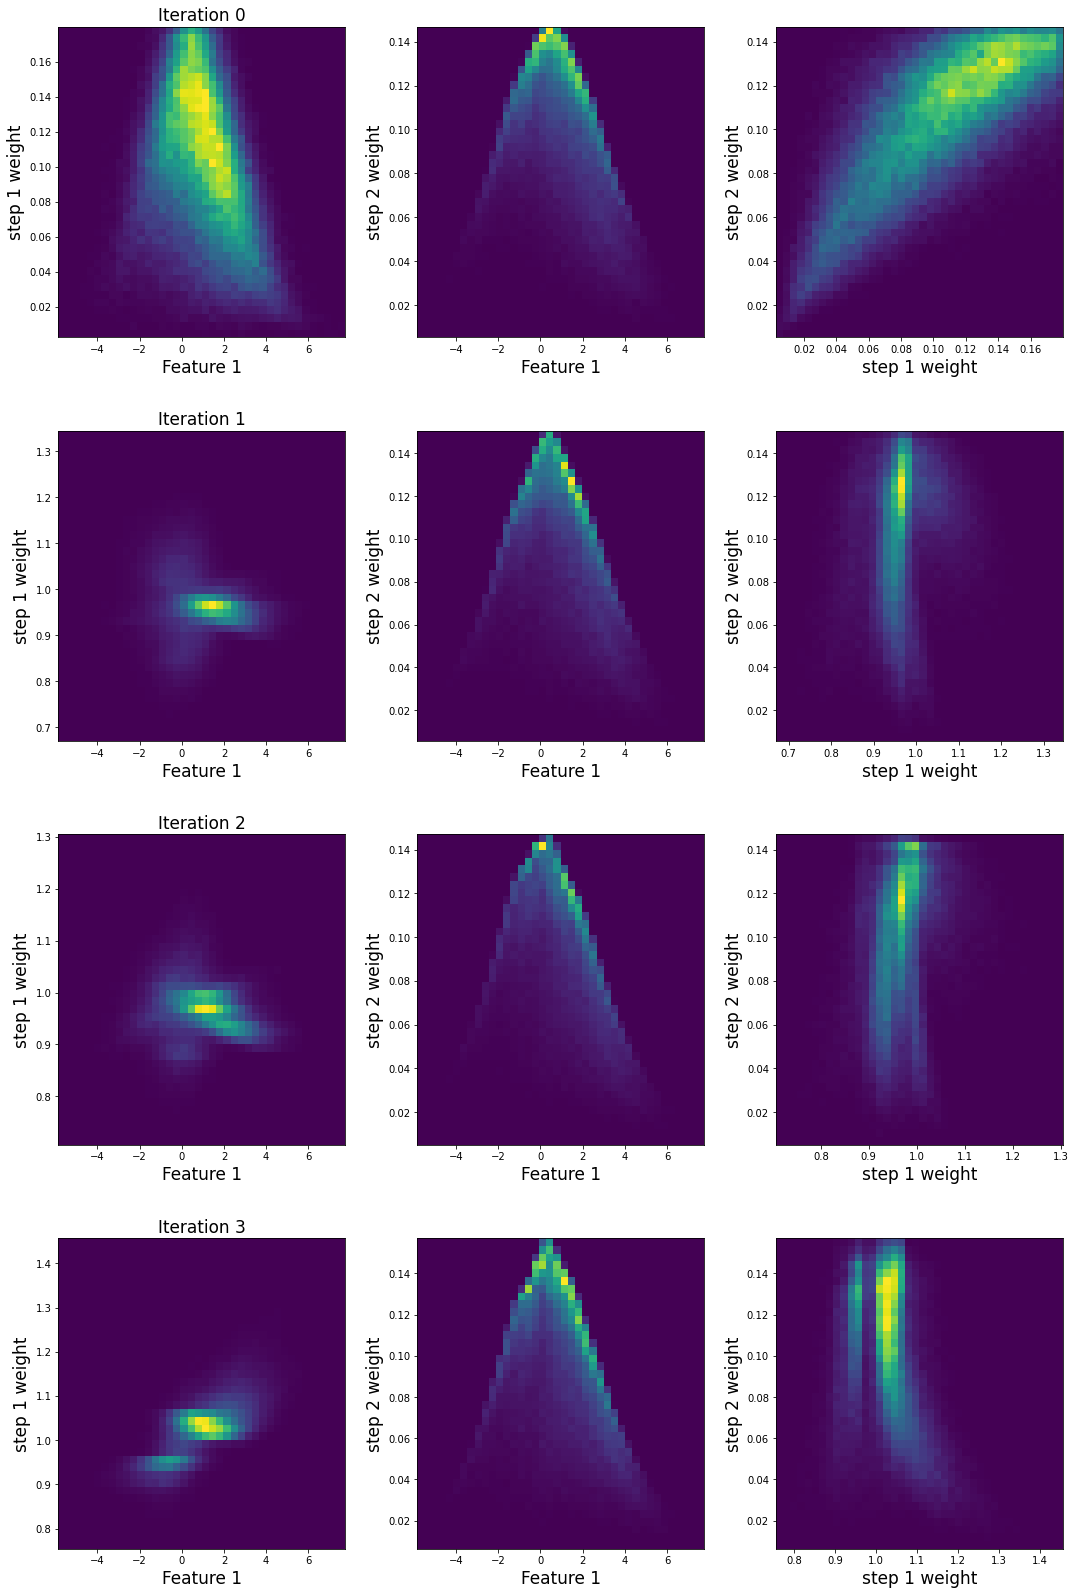

In [22]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist2d( train_pts[:,1], of_weights[ofi,0,:], bins=[hbins,hbins] )
    ax[ofi][1].hist2d( train_pts[:,1], of_weights[ofi,1,:], bins=[hbins,hbins] )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'Feature 1', fontsize=lfontsize )
    ax[ofi][0].set_ylabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'Feature 1', fontsize=lfontsize )
    ax[ofi][1].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

In [23]:
max_step2_weight = np.max( of_weights[3,1,:] )

<function matplotlib.pyplot.show(close=None, block=None)>

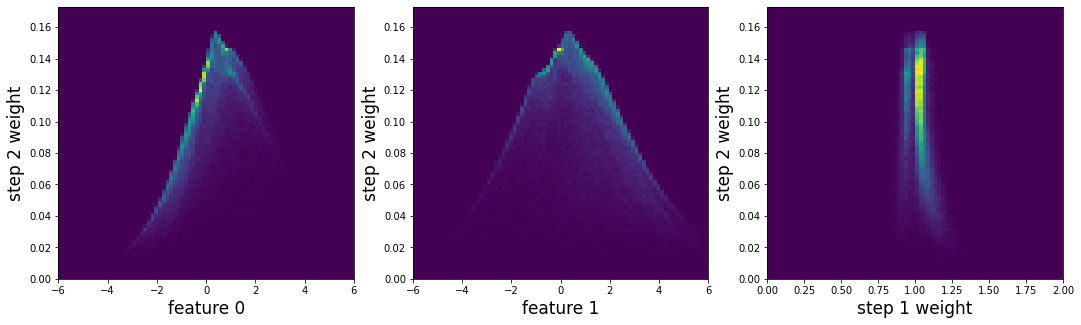

In [24]:
fig,ax = plt.subplots( 1, 3, figsize=(18,5))

hmin=-6
hmax=6
hbins=80

ax[0].hist2d( train_pts[:,0], of_weights[3,1,:], bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_step2_weight]))

ax[1].hist2d( train_pts[:,1], of_weights[3,1,:], bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_step2_weight]))

ax[2].hist2d( of_weights[3,0,:], of_weights[3,1,:], bins=[hbins,hbins], range=([0.,2.],[0.,1.1*max_step2_weight]))


lfontsize = 17

ax[0].set_xlabel( 'feature 0', fontsize=lfontsize )
ax[0].set_ylabel( 'step 2 weight', fontsize=lfontsize )


ax[1].set_xlabel( 'feature 1', fontsize=lfontsize )
ax[1].set_ylabel( 'step 2 weight', fontsize=lfontsize )

ax[2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
ax[2].set_ylabel( 'step 2 weight', fontsize=lfontsize )


plt.show


## Do the bootstrap samples in a loop

In [25]:
n_boot_samples = 5

do_bootstrap = True

verbose = False

bootstrap_weights = np.zeros( shape=(n_boot_samples, len(train_pts) ))

In [26]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = np.random.Generator.choice( true_det_pts, size=len(true_det_pts) )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, [res0, res1])
        
    boot_of_weights = of.omnifold( train_both, boot_true_det_pts, of_niter, model, verbose)
    
    bootstrap_weights[bi] = boot_of_weights[3,1,:]
    


 Creating bootstrap sample   0
10/10 [==============================] - 0s 3ms/step

 Creating bootstrap sample   1
10/10 [==============================] - 0s 3ms/step

 Creating bootstrap sample   2
10/10 [==============================] - 0s 2ms/step

 Creating bootstrap sample   3
10/10 [==============================] - 0s 3ms/step

 Creating bootstrap sample   4
10/10 [==============================] - 0s 3ms/step
CPU times: user 6min 24s, sys: 1min 15s, total: 7min 39s
Wall time: 2min 57s


In [27]:
bootstrap_weights

array([[0.0989669 , 0.11401062, 0.05678133, ..., 0.08659775, 0.12684928,
        0.07916863],
       [0.10403309, 0.11841437, 0.04972775, ..., 0.0914354 , 0.13170968,
        0.08378445],
       [0.11234586, 0.10391275, 0.05372281, ..., 0.09002077, 0.13404997,
        0.08050307],
       [0.0991605 , 0.12220546, 0.04705849, ..., 0.08905327, 0.12983544,
        0.075733  ],
       [0.10920288, 0.1232536 , 0.04838629, ..., 0.08966752, 0.140673  ,
        0.08789337]])

In [28]:
of_weights[3,1,:]

array([0.11273387, 0.11958432, 0.04598216, ..., 0.09617724, 0.13995498,
       0.0811051 ])

In [29]:
bootstrap_weights[0]

array([0.0989669 , 0.11401062, 0.05678133, ..., 0.08659775, 0.12684928,
       0.07916863])

In [30]:
np.cov( bootstrap_weights[:,0])

array(3.56813824e-05)

In [31]:
bootstrap_weights[:,100]

array([0.07561444, 0.08344654, 0.07334406, 0.08022721, 0.07710075])

<function matplotlib.pyplot.show(close=None, block=None)>

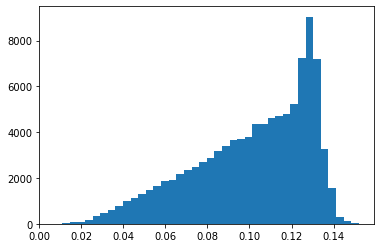

In [32]:
plt.hist( bootstrap_weights[1,:], bins=40)
plt.show

In [33]:
np.mean( bootstrap_weights, axis=0 )

array([0.10474185, 0.11635936, 0.05113533, ..., 0.08935494, 0.13262347,
       0.0814165 ])

In [34]:
bootstrap_w2 = bootstrap_weights * bootstrap_weights

In [35]:
bootstrap_w2

array([[0.00979445, 0.01299842, 0.00322412, ..., 0.00749917, 0.01609074,
        0.00626767],
       [0.01082288, 0.01402196, 0.00247285, ..., 0.00836043, 0.01734744,
        0.00701983],
       [0.01262159, 0.01079786, 0.00288614, ..., 0.00810374, 0.01796939,
        0.00648074],
       [0.0098328 , 0.01493417, 0.0022145 , ..., 0.00793049, 0.01685724,
        0.00573549],
       [0.01192527, 0.01519145, 0.00234123, ..., 0.00804026, 0.01978889,
        0.00772525]])

In [36]:
bootstrap_variance = np.mean( bootstrap_w2, axis=0 ) - np.mean( bootstrap_weights, axis=0 ) * np.mean( bootstrap_weights, axis=0 )

In [37]:
bootstrap_variance

array([2.85451059e-05, 4.92730342e-05, 1.29463108e-05, ...,
       2.51248766e-06, 2.17558341e-05, 1.71493044e-05])

In [38]:
bootstrap_rms = np.sqrt( bootstrap_variance )

In [39]:
bootstrap_rms

array([0.00534276, 0.00701948, 0.0035981 , ..., 0.00158508, 0.00466431,
       0.00414117])

In [40]:
col_vec = np.array([[11],[22],[33]])

In [41]:
col_vec

array([[11],
       [22],
       [33]])

In [42]:
row_vec = col_vec.T

In [43]:
row_vec

array([[11, 22, 33]])

In [44]:
col_times_row = col_vec * row_vec

In [45]:
col_times_row

array([[ 121,  242,  363],
       [ 242,  484,  726],
       [ 363,  726, 1089]])

In [46]:
col_vec.shape

(3, 1)

In [47]:
row_vec.shape

(1, 3)

In [48]:
col_times_row.shape

(3, 3)

In [49]:
row_times_col = row_vec * col_vec

In [50]:
row_times_col

array([[ 121,  242,  363],
       [ 242,  484,  726],
       [ 363,  726, 1089]])

In [51]:
row_times_row = row_vec * row_vec

In [52]:
row_times_row

array([[ 121,  484, 1089]])

In [53]:
row_dot_row = np.dot(row_vec,row_vec)

ValueError: shapes (1,3) and (1,3) not aligned: 3 (dim 1) != 1 (dim 0)

In [54]:
row_dot_col = np.dot(row_vec,col_vec)

In [55]:
row_dot_col

array([[1694]])

In [56]:
row_dot_col.shape

(1, 1)

In [57]:
col_dot_row = np.dot(col_vec,row_vec)

In [58]:
col_dot_row

array([[ 121,  242,  363],
       [ 242,  484,  726],
       [ 363,  726, 1089]])

In [59]:
bootstrap_weights.shape

(5, 100000)

In [60]:
bootstrap_weights.T

array([[0.0989669 , 0.10403309, 0.11234586, 0.0991605 , 0.10920288],
       [0.11401062, 0.11841437, 0.10391275, 0.12220546, 0.1232536 ],
       [0.05678133, 0.04972775, 0.05372281, 0.04705849, 0.04838629],
       ...,
       [0.08659775, 0.0914354 , 0.09002077, 0.08905327, 0.08966752],
       [0.12684928, 0.13170968, 0.13404997, 0.12983544, 0.140673  ],
       [0.07916863, 0.08378445, 0.08050307, 0.075733  , 0.08789337]])

In [61]:
bootstrap_weights.T.shape

(100000, 5)

In [62]:
bootstrap_weights_dot = np.dot( bootstrap_weights, bootstrap_weights.T )

In [63]:
bootstrap_weights_dot

array([[1016.93978322, 1056.48565864, 1005.37869007, 1030.34868895,
        1074.0611038 ],
       [1056.48565864, 1101.67711356, 1045.8199009 , 1071.59760152,
        1117.81342973],
       [1005.37869007, 1045.8199009 ,  997.74192182, 1019.33432303,
        1063.37222794],
       [1030.34868895, 1071.59760152, 1019.33432303, 1045.77862343,
        1089.24341557],
       [1074.0611038 , 1117.81342973, 1063.37222794, 1089.24341557,
        1138.59876863]])

In [64]:
bootstrap_weights_dot.shape

(5, 5)

In [ ]:
#bootstrap_weights_dot2 = np.dot( bootstrap_weights.T, bootstrap_weights )

In [ ]:
#bootstrap_weights_dot2